# Mask Detection using Neural Netwrok.

This is the code to classify(binary) images as cat or dogs using Neural networks.

## Importing required packages

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import pathlib
import os
from xml.etree import ElementTree as ET

## Setting device to GPU if available, will be using this everywhere

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Will use {}'.format(device))

Will use cuda


## Reading data and performing a little preprocessing

Annotations file for each image has information such as filename of the image, objects having masks or not, bounding box of the object. Fetching required information from all the annotations.

In [46]:
annotations = [ET.parse('Data/annotations/'+a) for a in os.listdir('Data/annotations')]

In [67]:
info = []
for a in annotations:
    for detection in a.findall('object'):
        info.append(
            (
                a.find('filename').text,
                detection.find('name').text,
                detection.find('bndbox').find('xmin').text,
                detection.find('bndbox').find('ymin').text,
                detection.find('bndbox').find('xmax').text,
                detection.find('bndbox').find('ymax').text
            )
        )

Reading each object and it's target class.

In [327]:
x = []
y = []
for i in info:
    file,cls,xmin,ymin,xmax,ymax = i
    if cls == 'with_mask':
        cls = 1
    else:
        cls = 0
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    img = cv2.imread('Data/images/'+file)
    img = img[ymin:ymax,xmin:xmax]
    x.append(img)
    y.append(cls)

print(len(x),len(y))

4072 4072


Preprocessing

In [122]:
def img_squared(img):
    h,w,c = img.shape
    if w < h:
        img = np.concatenate((img,np.zeros((h,h-w,c),dtype=np.int32)),axis=1)
    elif h < w:
        img = np.concatenate((img,np.zeros((w-h,w,c),dtype=np.int32)))
    return img

In [328]:
x = [cv2.cvtColor(img,cv2.COLOR_BGR2RGB) for img in x]
x = [img_squared(img) for img in x]
x = [cv2.resize(img.astype('uint8'),(64,64)) for img in x]
x = torch.Tensor(x)/255

y = torch.Tensor(y)

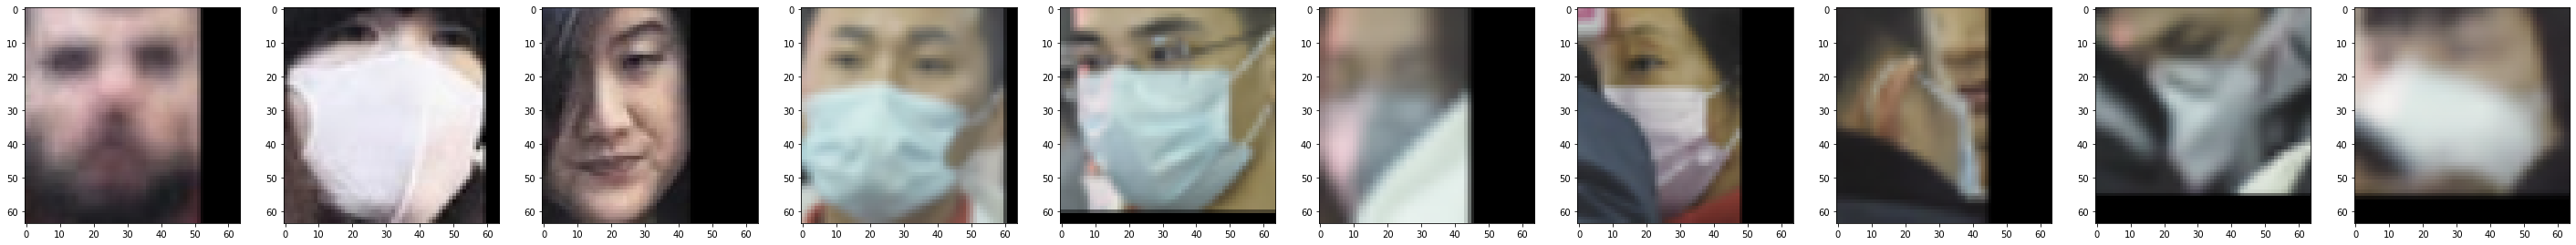

In [127]:
fig,ax = plt.subplots(1,10, figsize=(50,500))
for i in range(10):
    ax[i].imshow(x[i])

Flatenning the images to input tensor.

In [141]:
m,h,w,c = x.shape
x_flat = x.reshape(m,-1)

splitting to test and train datasets.

In [329]:
x_train, x_test, y_train, y_test = train_test_split(x_flat,y,test_size=0.2)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

## Defining Neural Network Model

In [240]:
class Model2(nn.Module):
    def __init__(self,features):
        super().__init__()
        self.Z1 = nn.Linear(features,20)
        self.Z2 = nn.Linear(20,7)
        self.Z3 = nn.Linear(7,5)
        self.Z4 = nn.Linear(5,1)        
        #self.initialize_weights()
    
    def forward(self,X):
        X = F.relu(self.Z1(X))
        X = F.relu(self.Z2(X))
        X = F.relu(self.Z3(X))
        X = torch.sigmoid(self.Z4(X))
        return X
    
    def initialize_weights(self):
        nn.init.xavier_uniform_(self.Z1.weight)
        nn.init.xavier_uniform_(self.Z2.weight)
        nn.init.xavier_uniform_(self.Z3.weight)
        nn.init.xavier_uniform_(self.Z4.weight)        

In [337]:
torch.manual_seed(1)
n = h*w*c
classifier = Model2(n).to(device)
losses=[]
optimizer = optim.Adam(classifier.parameters(), lr=0.00001)
classifier

Model2(
  (Z1): Linear(in_features=12288, out_features=20, bias=True)
  (Z2): Linear(in_features=20, out_features=7, bias=True)
  (Z3): Linear(in_features=7, out_features=5, bias=True)
  (Z4): Linear(in_features=5, out_features=1, bias=True)
)

Training Neural Network.

In [331]:
with torch.no_grad():
    out = classifier(x_test)>0.5
    out = out.int().reshape((x_test.shape[0]))
    comp = out == y_test
    comp = int(comp.sum())
    test_acc = comp/x_test.shape[0]
    print('Test accuracy: {} \nClassified {} correct out of {}'.format(test_acc,comp,x_test.shape[0]))

Test accuracy: 0.6368098159509202 
Classified 519 correct out of 815


Epoch:0 loss:0.21181151270866394
Epoch:500 loss:0.20503006875514984
Epoch:1000 loss:0.1961304098367691
Epoch:1500 loss:0.18891772627830505
Epoch:2000 loss:0.18223969638347626
Epoch:2500 loss:0.1726229339838028


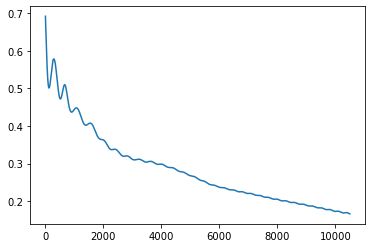

In [343]:
for i in range(11000):
    y_hat = classifier(x_train)
    finder.zero_grad()
    loss = F.binary_cross_entropy(y_hat,y_train.reshape((x_train.shape[0],1)))
    losses.append(loss)
    loss.backward()
    optimizer.step()
    if i%500 == 0:
        print('Epoch:{} loss:{}'.format(i,loss))
plt.plot(losses)

In [344]:
with torch.no_grad():
    out = classifier(x_train)>0.5
    out = out.int().reshape((x_train.shape[0]))
    comp = out == y_train
    comp = int(comp.sum())
    train_acc = comp/x_train.shape[0]
    print('Test accuracy: {} \nClassified {} correct out of {}'.format(train_acc,comp,x_train.shape[0]))

Test accuracy: 0.9447344181762358 
Classified 3077 correct out of 3257


In [345]:
with torch.no_grad():
    out = classifier(x_test)>0.5
    out = out.int().reshape((x_test.shape[0]))
    comp = out == y_test
    comp = int(comp.sum())
    test_acc = comp/x_test.shape[0]
    print('Test accuracy: {} \nClassified {} correct out of {}'.format(test_acc,comp,x_test.shape[0]))

Test accuracy: 0.9460122699386503 
Classified 771 correct out of 815


In [346]:
comp = out == y_test
imgs = x_test[:].to('cpu').reshape(x_test.shape[0],h,w,c)
wrongs = []
for i in range(len(comp)):
    if comp[i]==False:
        wrongs.append((imgs[i],y_test[i],out[i]))

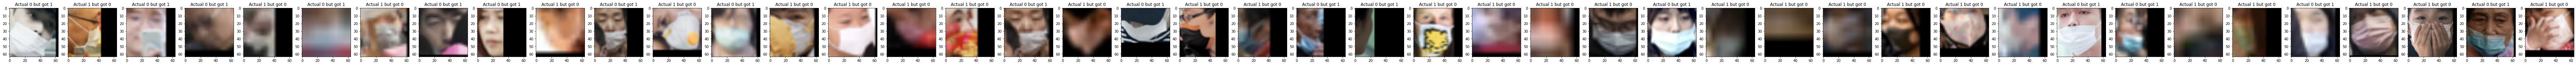

In [356]:
fig,ax = plt.subplots(1,len(wrongs),figsize=(len(wrongs)*3,3))
for i in range(len(wrongs)):
    img,t,o = wrongs[i]
    ax[i].imshow(img)
    ax[i].title.set_text('Actual {} but got {}'.format(int(t),int(o)))